Answer 4


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


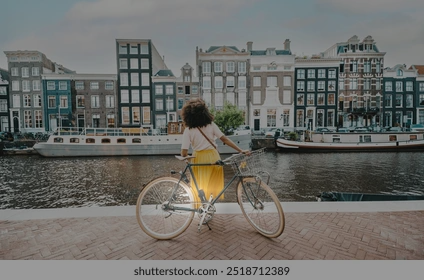

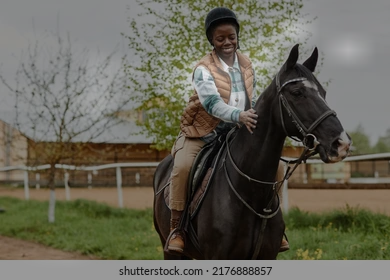

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from IPython.display import Image
import matplotlib.pyplot as plt

# Helper function to preprocess and load an image
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg16.preprocess_input(img)  # VGG16 preprocessing
    return img

# Grad-CAM implementation
def generate_gradcam(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# Helper function to save the Grad-CAM heatmap visualization
def save_gradcam(image_path, heatmap, alpha=0.4):
    # Load the original image
    img = load_img(image_path)
    img = img_to_array(img)

    # Process the heatmap
    heatmap = np.uint8(255 * heatmap)  # Scale heatmap to [0, 255]
    heatmap = tf.image.resize(heatmap[..., np.newaxis], (img.shape[0], img.shape[1])).numpy()
    heatmap = np.repeat(heatmap, 3, axis=-1)  # Make it RGB by repeating across channels

    # Overlay the heatmap on the original image
    overlayed_image = img * (1 - alpha) + heatmap * alpha

    # Save the Grad-CAM visualization
    gradcam_path = image_path.split("/")[-1].split(".")[0] + "_grad_cam.png"
    plt.imsave(gradcam_path, overlayed_image.astype("uint8"))
    return gradcam_path


# Paths and model setup
IMAGE_PATHS = ['img1.webp', 'img2.webp']  # Replace with actual paths
indices = [263, 281]  # Replace with desired class indices
last_conv_layer_name = "block5_conv3"

# Load the pre-trained VGG16 model
model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)

# Generate Grad-CAM heatmaps and save visualizations
for i in range(len(IMAGE_PATHS)):
    each_path = IMAGE_PATHS[i]
    index = indices[i]

    img_array = preprocess_image(each_path)
    heatmap = generate_gradcam(model, img_array, last_conv_layer_name, pred_index=index)

    gradcam_path = save_gradcam(each_path, heatmap)
    display(Image(filename=gradcam_path))


Answer 5 (Only Prediction)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50, InceptionV3, MobileNetV2, NASNetLarge, ResNet152
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import requests
from io import BytesIO
from PIL import Image

# Function to load and preprocess an image from a URL
def load_and_preprocess_image(image_url, target_size):
    try:
        response = requests.get(image_url, stream=True)
        response.raise_for_status()  # Raise an exception for bad status codes
        img = Image.open(BytesIO(response.content)).convert('RGB')  # Convert to RGB to handle grayscale
        img = img.resize(target_size)  # Resize the image to match model input size
        x = image.img_to_array(img)  # Convert image to array
        x = np.expand_dims(x, axis=0)  # Add batch dimension
        x = preprocess_input(x)  # Preprocess the image for the model
        return x
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
        return None
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# Models to use
models = {
    "ResNet50": ResNet50(weights='imagenet'),
    "ResNet152": ResNet152(weights='imagenet'),
    "InceptionV3": InceptionV3(weights='imagenet'),
    "MobileNetV2": MobileNetV2(weights='imagenet'),
    "NASNetLarge": NASNetLarge(weights='imagenet')
}

# Example image URLs (replace with your own)
image_urls = [
    "https://media.istockphoto.com/id/184276818/photo/red-apple.jpg?s=612x612&w=0&k=20&c=NvO-bLsG0DJ_7Ii8SSVoKLurzjmV0Qi4eGfn6nW3l5w=",  # apple
    "https://images.pexels.com/photos/220762/pexels-photo-220762.jpeg?cs=srgb&dl=pexels-pixabay-220762.jpg&fm=jpg",  # bridge
    "https://cdn.britannica.com/07/5207-050-5BC9F251/Gray-wolf.jpg"  # wolf
]

# Process each model and image
for model_name, model in models.items():
    print(f"\n--- {model_name} ---")
    target_size = model.input_shape[1:3]  # Get the input size of the model

    for image_url in image_urls:
        print(f"\nProcessing image: {image_url}")
        img = load_and_preprocess_image(image_url, target_size)
        if img is None:
            continue

        predictions = model.predict(img)

        # Decode predictions for ResNet50 and other models
        if model_name == "ResNet50" or model_name == "ResNet152":
            decoded_predictions = decode_predictions(predictions, top=3)[0]
        else:  # For InceptionV3, MobileNetV2, and NASNetLarge
            decoded_predictions = keras.applications.imagenet_utils.decode_predictions(predictions, top=3)[0]

        print("Predictions:")
        for i, (imagenet_id, label, prob) in enumerate(decoded_predictions):
            print(f"{i+1}: {label} ({prob:.2f})")


242900224/242900224 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
359748576/359748576 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

--- ResNet50 ---

Processing image: https://media.istockphoto.com/id/184276818/photo/red-apple.jpg?s=612x612&w=0&k=20&c=NvO-bLsG0DJ_7Ii8SSVoKLurzjmV0Qi4eGfn6nW3l5w=
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predictions:
1: Granny_Smith (0.29)
2: pomegranate (0.24)
3: banana (0.08)

Processing image: https://images.pexels.com/photos/220762/pexels-photo-220762.jpeg?cs=srgb&dl=pexels-pixabay-220762.jpg&fm=jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Predictions:
1: suspension_bridge (0.92)
2: pier (0.06)
3: steel_arch_bridge (0.01)

Processing image: https://cdn.britannica.com/07/5207-050-5BC9F251/Gray-wolf.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Predictions:
1: timber_wolf (0.94)
2: white_wolf (0.03)
3: red_wolf (0.02)

--- ResNet152 ---

Processing image: https://media.istockphoto.com/id/184276818/photo/red-apple.jpg?s=612x612&w=0&k=20&c=NvO-bLsG0DJ_7Ii8SSVoKLurzjmV0Qi4eGfn6nW3l5w=


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Predictions:
1: Granny_Smith (0.48)
2: paper_towel (0.09)
3: pomegranate (0.06)

Processing image: https://images.pexels.com/photos/220762/pexels-photo-220762.jpeg?cs=srgb&dl=pexels-pixabay-220762.jpg&fm=jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
Predictions:
1: suspension_bridge (0.66)
2: pier (0.32)
3: steel_arch_bridge (0.02)

Processing image: https://cdn.britannica.com/07/5207-050-5BC9F251/Gray-wolf.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
Predictions:
1: timber_wolf (0.89)
2: red_wolf (0.04)
3: white_wolf (0.03)

--- InceptionV3 ---

Processing image: https://media.istockphoto.com/id/184276818/photo/red-apple.jpg?s=612x612&w=0&k=20&c=NvO-bLsG0DJ_7Ii8SSVoKLurzjmV0Qi4eGfn6nW3l5w=


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predictions:
1: web_site (0.98)
2: pitcher (0.01)
3: spotlight (0.00)

Processing image: https://images.pexels.com/photos/220762/pexels-photo-220762.jpeg?cs=srgb&dl=pexels-pixabay-220762.jpg&fm=jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
Predictions:
1: web_site (1.00)
2: stopwatch (0.00)
3: sunglass (0.00)

Processing image: https://cdn.britannica.com/07/5207-050-5BC9F251/Gray-wolf.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
Predictions:
1: stopwatch (1.00)
2: vase (0.00)
3: hammer (0.00)

--- MobileNetV2 ---

Processing image: https://media.istockphoto.com/id/184276818/photo/red-apple.jpg?s=612x612&w=0&k=20&c=NvO-bLsG0DJ_7Ii8SSVoKLurzjmV0Qi4eGfn6nW3l5w=
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predictions:
1: mouse (0.05)
2: microphone (0.04)
3: perfume (0.04)

Processing image: https://images.pexels.com/photos/220762/pexels-photo-220762.jpeg?cs=srgb&dl=pexels-pixabay-220762.jpg&fm=jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predictions:
1: suspension_bridg

Code to Plot and Predict Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


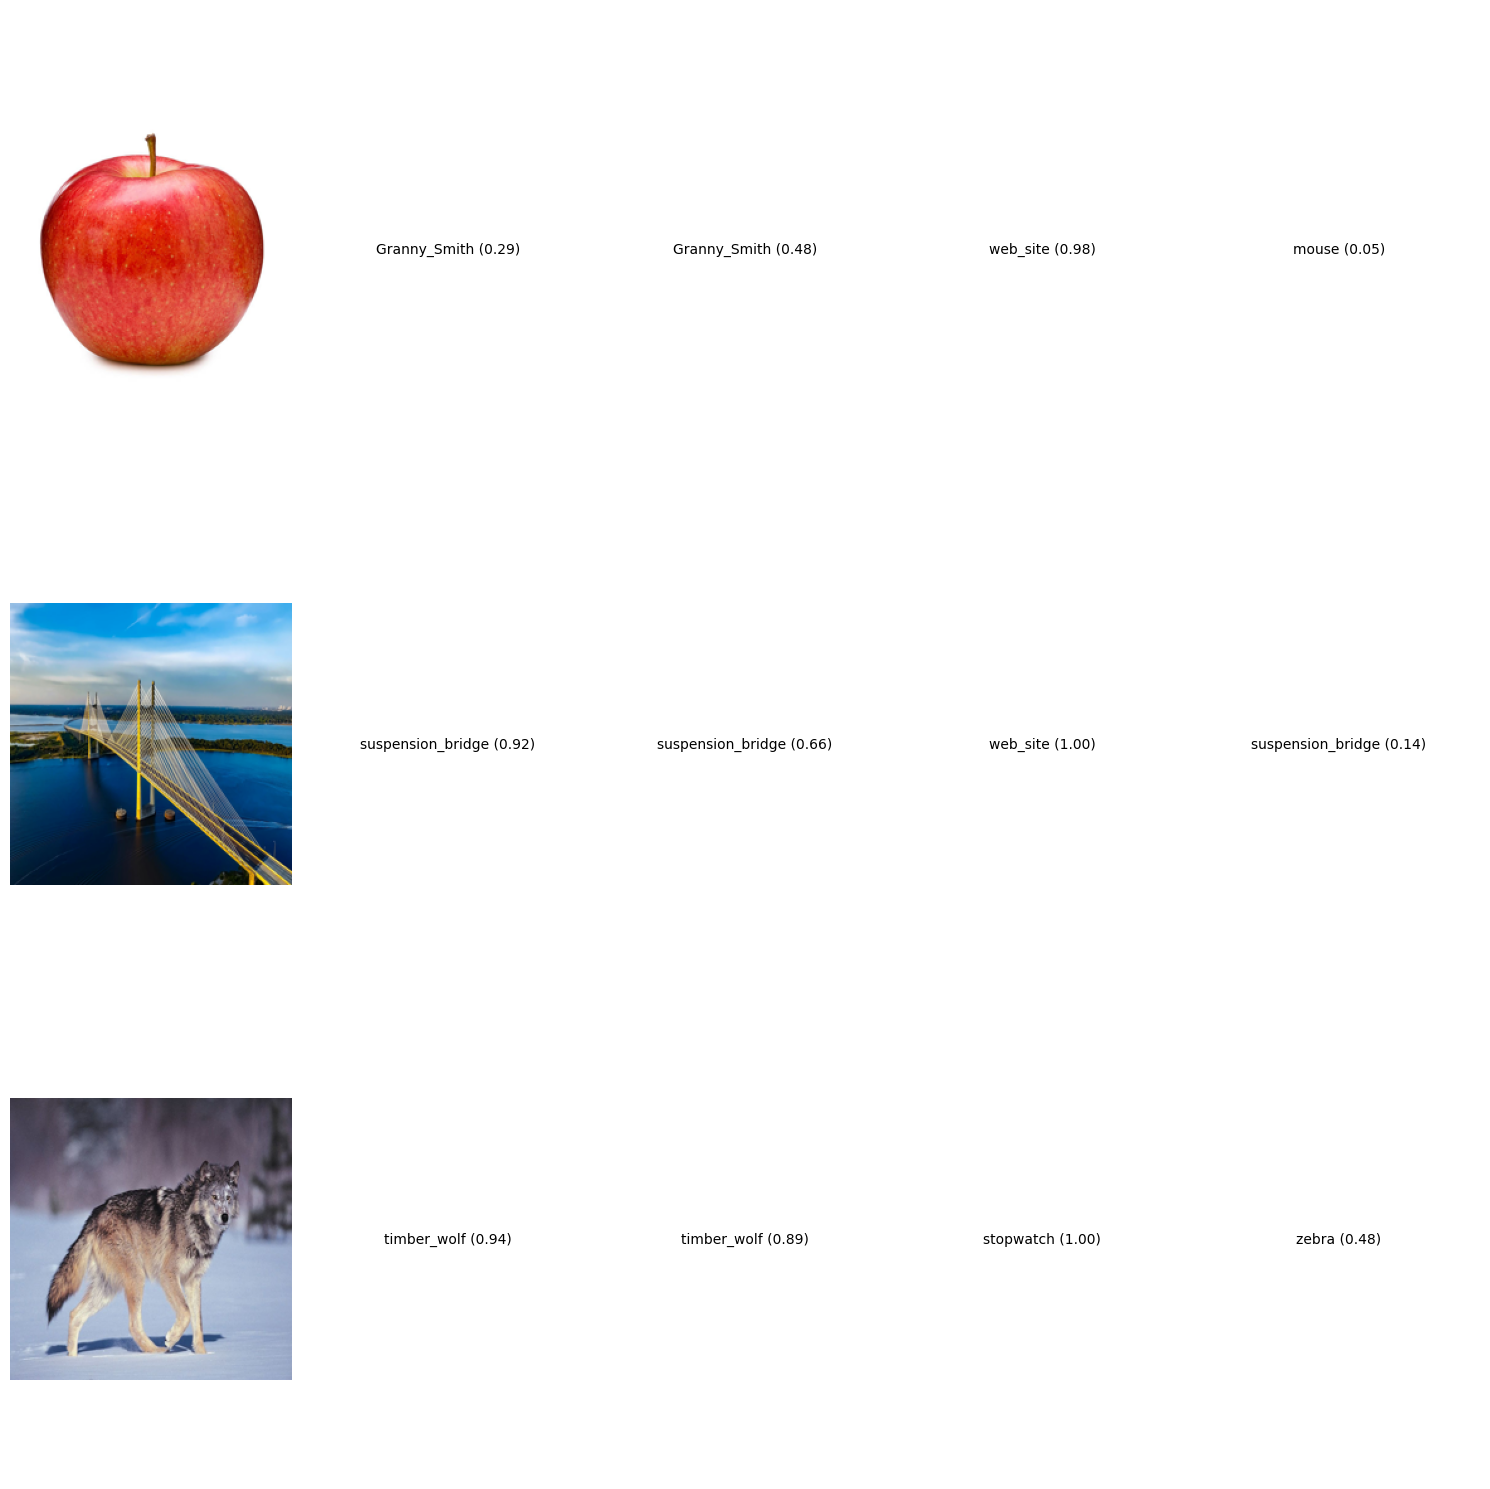

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50, InceptionV3, MobileNetV2, NASNetLarge, ResNet152
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import requests
from io import BytesIO
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

# Function to load and preprocess an image from a URL
def load_and_preprocess_image(image_url, target_size):
    try:
        response = requests.get(image_url, stream=True)
        response.raise_for_status()  # Raise an exception for bad status codes
        img = Image.open(BytesIO(response.content)).convert('RGB')  # Convert to RGB to handle grayscale
        img = img.resize(target_size)  # Resize the image to match model input size
        x = image.img_to_array(img)  # Convert image to array
        x = np.expand_dims(x, axis=0)  # Add batch dimension
        x = preprocess_input(x)  # Preprocess the image for the model
        return img, x
    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
        return None, None
    except Exception as e:
        print(f"Error processing image: {e}")
        return None, None

# Models to use
models = {
    "ResNet50": {"model": ResNet50(weights='imagenet'), "input_size": (224, 224)},
    "ResNet152": {"model": ResNet152(weights='imagenet'), "input_size": (224, 224)},
    "InceptionV3": {"model": InceptionV3(weights='imagenet'), "input_size": (299, 299)},
    "MobileNetV2": {"model": MobileNetV2(weights='imagenet'), "input_size": (224, 224)}
}

# Example image URLs (replace with your own)
image_urls = [
    "https://media.istockphoto.com/id/184276818/photo/red-apple.jpg?s=612x612&w=0&k=20&c=NvO-bLsG0DJ_7Ii8SSVoKLurzjmV0Qi4eGfn6nW3l5w=",  # apple
    "https://images.pexels.com/photos/220762/pexels-photo-220762.jpeg?cs=srgb&dl=pexels-pixabay-220762.jpg&fm=jpg",  # bridge
    "https://cdn.britannica.com/07/5207-050-5BC9F251/Gray-wolf.jpg"  # wolf
]

# Prepare an empty list to store table rows
table_data = []

# Process each image
for image_url in image_urls:
    row = []  # Each row will store the image and model predictions

    # Load and preprocess image for each model
    row_images = []
    for model_name, model_info in models.items():
        img, img_array = load_and_preprocess_image(image_url, target_size=model_info["input_size"])

        if img is None:
            continue

        row_images.append(img)  # Add the image to the row

        # Get predictions
        model = model_info["model"]
        predictions = model.predict(img_array)

        # Decode predictions
        if model_name == "ResNet50" or model_name == "ResNet152":
            decoded_predictions = decode_predictions(predictions, top=1)[0]  # Top 1 prediction
        else:
            decoded_predictions = keras.applications.imagenet_utils.decode_predictions(predictions, top=1)[0]

        label, prob = decoded_predictions[0][1], decoded_predictions[0][2]
        row.append(f"{label} ({prob:.2f})")  # Add prediction to the row

    # Append the row to the table data
    table_data.append([row_images] + row)

# Convert the table data into a pandas DataFrame
columns = ["Image"] + list(models.keys())
df = pd.DataFrame(table_data, columns=columns)

# Display the table with images and predictions
fig, axes = plt.subplots(len(image_urls), len(models) + 1, figsize=(15, 5 * len(image_urls)))

for i, row in enumerate(df.values):
    for j, cell in enumerate(row):
        if j == 0:  # Display the image in the first column
            axes[i, j].imshow(df.iloc[i, j][0])  # Display image
            axes[i, j].axis("off")  # Hide axis
        else:  # Display predictions in other columns
            axes[i, j].text(0.5, 0.5, cell, ha='center', va='center', fontsize=10)
            axes[i, j].axis('off')  # Hide axis

plt.tight_layout()
plt.show()
